# Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import wget
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Creating and training binary classification model

Method loadDataFromDirectorySplit() is responsible for loading data, getting a class label from name of the file and spliting singals into smaller parts. Splitting data is the first preprocessing done in the project. While working on the 
solution I frequently stumbled upon OOM errors. Data was simply to big for my PC to be loaded at once. After some tries to compress the whole given signal, which gave poor results, I tried splitting signal into smaller pieces. It would decrease amount of memory needed to train the model but in order to use that solution I had to chceck if smaller parts are descriptive enough to use them in training the model.

In [2]:
if not os.path.isdir('data.resistell.com'):
    !wget -r --user=modelway --password=M0delWay! --reject="index.html" https://data.resistell.com/model_way/ds_recruitment/
    os.remove("data.resistell.com\model_way\ds_recruitment\index.html.tmp")

In [3]:
directory = 'data.resistell.com/model_way/ds_recruitment'
def loadDataFromDirectorySplit(directory, class_index):
    tmp_x = []
    tmp_y = []
    for filename in os.listdir(directory):
        file = os.path.join(directory, filename)
        with open(file, 'rb') as f:
            tmp = pickle.load(f) # deserialize using load()
            split_tmp = np.array_split(tmp, 128)
            for n in range(0,128):
                tmp_y.append(int(file[class_index]))
            tmp_x.append(split_tmp)
    return(tmp_x, tmp_y)

Method makeModel() creates architecture for convolutional neural network. I used CNN because of its ability to detect patterns and classify objects. It is most generally used for images but it can manage detecting patterns in 1D signals. That functionality is supported in keras library. The architecture is standard. Four convolutional layers are used, each with increasing number of filters in order to make them more and more specialised. After each layer model does pooling which should prevent overfitting. After last convolutional layer dropout is used to minimize overfitting. Nexty method Flatten() is used to tansform 3D to 1D tensor. Flattened tensor is given to two fully connected layers with increasing number of neurons. The output from second fully connected layer is given to a layer with only one neuron with sigmoid activation function. It is the recommended output layer for binary classification. All prevoius layers use ReLU activation function.

In [4]:
def makeModel(input_shape):
    
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=input_shape))
    model.add(MaxPooling1D(4))
    model.add(Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=input_shape))
    model.add(MaxPooling1D(4))
    model.add(Conv1D(filters=96, kernel_size=3, activation="relu", input_shape=input_shape))
    model.add(MaxPooling1D(4))
    model.add(Conv1D(filters=128, kernel_size=3, activation="relu", input_shape=input_shape))
    model.add(MaxPooling1D(4))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [5]:
data, classes = loadDataFromDirectorySplit(directory, 60)

Method flatten() is used to change dimensions of split data. The output of data form 'loadDataFromDirectorySplit(directory)' is arranged like this:<br> 
[np.arr([...], ..., [...]), ..., np.arr([...], ..., [...])]<br>
Preferable output should look as follows:<br>
[[...], ..., [...]]<br>
Method flatten() does exacly that. In short it is used to unnest inner arrays in a list. 

In [6]:
def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

In [7]:
data = flatten(data)

In [8]:
len(data)

12672

In [9]:
data[0]

array([-0.30123123, -0.98397377,  0.30727141, ..., -0.48290587,
        4.13641472, -0.83893853])

In [10]:
lin_x = np.linspace(1, len(data[1]), num = len(data[1]))
lin_x

array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 3.9998e+04, 3.9999e+04,
       4.0000e+04])

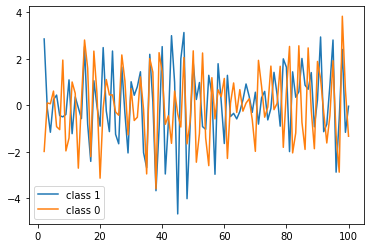

In [11]:
plt.figure()
plt.plot(lin_x[1:100], data[1][1:100], label = "class 1")
plt.plot(lin_x[1:100], data[2][1:100], label = "class 0")
plt.legend(loc="best")
plt.show()

As the next part of preprocessing, in the for loop below I standardize the data. It is a common practise to boost models effectivness. By scaling the features to have a similar range, it makes it easier for the model to learn the relevant patterns and relationships between the input features and the target variable.

In [12]:
for i, j in enumerate(data): 
    data[i] = (j - j.mean())/(j.std())

In the cell below I check if there are any NaNs in the signals. Fortunatly, there was no missing values so interpolation wasn't needed. Moreover, each signal has the same length so I didn't have to add values to shorter ones or cut inputs from longer ones.

In [13]:
for i, j in enumerate(data):
    if np.count_nonzero(np.isnan(j)) != 0:
        print("There is a NaN in array number " + str(i) + " and there are " + str(np.count_nonzero(np.isnan(j))))

In [14]:
data = np.array(data)
classes = np.array(classes)
data = data.reshape((data.shape[0], data.shape[1], 1))

I split data and classes into training and testing subsets. Training subset contains 80% and test subset contains 20% of data and classes arrays. 

In [15]:
data_train, data_test, classes_train, classes_test = train_test_split(np.float16(data), classes, test_size=0.20, random_state=42)

In the cell below I delete arrays containg data and classes and free up memory. They will not be used during training and as I stated before OOM errors are a common problem so the more memory I have to work with, the better.

In [16]:
del data
del classes
gc.collect()

3426

In [17]:
model = makeModel(input_shape=data_train.shape[1:])

Here I am preparing model and training it. I set epoch to 500 but due to early stopping it stops much earlier. As the optimizer I use "adam" which is a combination of two optimizers: RmSprop and momentum. RMSprop is an algorithm that adjusts the learning rate for each parameter based on the gradients of the recent past, and momentum is an algorithm that helps the optimizer to move quicker through the parameter space by adding a fraction of the previous update to the current update. By combining these two methods, Adam is able to adaptively adjust the learning rate for each parameter while also providing momentum to help the optimizer move quicker through the parameter space.<br>
As the loss function I used "binary_crossentropy" which is standard for binary classification models. Metric is set to the simple accuracy.<br> 
Best model, based on value of loss function on the test subset, is stored on in a file called "best_model.h5". Later on, with method model.load() I can use the model to predict classes or evaluate model.

In [18]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    data_train,
    classes_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(data_test, classes_test),
    verbose=1,
)

Epoch 1/500
317/317 [==============================] - 21s 43ms/step - loss: 0.6641 - accuracy: 0.6159 - val_loss: 0.6343 - val_accuracy: 0.7030 - lr: 0.0010
Epoch 2/500
317/317 [==============================] - 12s 39ms/step - loss: 0.6002 - accuracy: 0.6953 - val_loss: 0.6652 - val_accuracy: 0.6454 - lr: 0.0010
Epoch 3/500
317/317 [==============================] - 12s 39ms/step - loss: 0.5635 - accuracy: 0.7330 - val_loss: 0.5958 - val_accuracy: 0.6828 - lr: 0.0010
Epoch 4/500
317/317 [==============================] - 12s 39ms/step - loss: 0.5064 - accuracy: 0.7645 - val_loss: 0.4351 - val_accuracy: 0.8170 - lr: 0.0010
Epoch 5/500
317/317 [==============================] - 13s 40ms/step - loss: 0.3544 - accuracy: 0.8407 - val_loss: 0.2859 - val_accuracy: 0.8761 - lr: 0.0010
Epoch 6/500
317/317 [==============================] - 13s 41ms/step - loss: 0.2900 - accuracy: 0.8736 - val_loss: 0.5926 - val_accuracy: 0.7045 - lr: 0.0010
Epoch 7/500
317/317 [==============================]

317/317 [==============================] - 14s 44ms/step - loss: 0.0072 - accuracy: 0.9978 - val_loss: 0.3780 - val_accuracy: 0.8935 - lr: 2.5000e-04
Epoch 53/500
317/317 [==============================] - 14s 44ms/step - loss: 0.0061 - accuracy: 0.9974 - val_loss: 0.4077 - val_accuracy: 0.8955 - lr: 2.5000e-04
Epoch 54/500
317/317 [==============================] - 14s 44ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.5339 - val_accuracy: 0.8868 - lr: 2.5000e-04
Epoch 55/500
317/317 [==============================] - 14s 44ms/step - loss: 0.0060 - accuracy: 0.9979 - val_loss: 0.4539 - val_accuracy: 0.8966 - lr: 2.5000e-04
Epoch 56/500
317/317 [==============================] - 14s 44ms/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.3935 - val_accuracy: 0.9014 - lr: 2.5000e-04
Epoch 57/500
317/317 [==============================] - 14s 43ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.4406 - val_accuracy: 0.8966 - lr: 2.5000e-04
Epoch 58/500
317/317 [=============

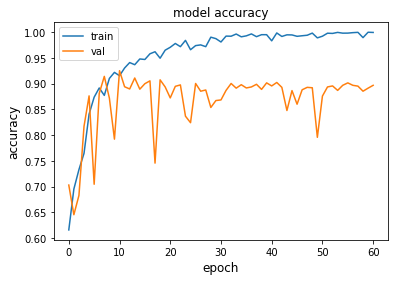

In [19]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [20]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(data_test, classes_test, batch_size=32)
pred_test= model.predict(data_test, batch_size=32)
print("Predictions", pred_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

80/80 [==============================] - 1s 15ms/step
Predictions [[0.9997545 ]
 [0.9993043 ]
 [0.9926434 ]
 ...
 [0.5230185 ]
 [0.6363239 ]
 [0.83377314]]
Test accuracy 0.9250493049621582
Test loss 0.1827186495065689


In [21]:
ttt = (pred_test > 0.5).astype(int).reshape(1,-1)
print(len(ttt[0]), len(classes_test))
confusion_matrix(ttt[0], np.array(classes_test))

2535 2535


array([[1154,  110],
       [  80, 1191]], dtype=int64)

In the cells above one can see that model is very accurate. Best model has accuracy of around 93% which is very high. Important thing to remember is that model created in this project is classifing only small parts of the signal. I can use that information to my advantage and boost accuracy even more. If I load data, split it into smaller pieces and make prediction on them using pretrained model I can then combine predictions for each part together, check which class appears more often and then label the whole signal as that class. In method makePrediction() I did exacly that. Method takes in two lists, data and classes, and a path to the file with the model. Method makePrediction() splits the data, multiplies classes so they will match split data, standardizes the data and makes predictions with the loaded model. The output of the method is the array of predicted classes for each signal in the input.

In [22]:
def loadDataFromDirectory(directory, class_index):
    tmp_x = []
    tmp_y = []
    for filename in os.listdir(directory):
        file = os.path.join(directory, filename)
        with open(file, 'rb') as f:
            tmp = pickle.load(f) # deserialize using load()
            tmp_y.append(int(file[class_index]))
            tmp_x.append(tmp)
    return(tmp_x, tmp_y)

In [23]:
data_t, classes_t = loadDataFromDirectory(directory, 60)

In [24]:
def makePrediction(data, classes, path_to_model):
    result = []
    split_data = []
    multiplied_classes = []
    length = len(data)
    
    if length != len(classes):
        print("Dimensions of data and classes don't match!")
        return -1
    
    for i in range(0, length):
        split_data.append(np.array_split(data[i], 128))
        for n in range(0,128):
                multiplied_classes.append(int(classes[i]))
    
    
    split_data = flatten(split_data)
    for i, j in enumerate(split_data):
        split_data[i] = (j - j.mean())/(j.std())
    split_data = np.array(split_data)
    multiplied_classes = np.array(multiplied_classes)
    split_data = split_data.reshape((split_data.shape[0], split_data.shape[1], 1))
    model = keras.models.load_model(path_to_model)
    loss, acc = model.evaluate(split_data, multiplied_classes, batch_size=32)
    prediction = model.predict(split_data, batch_size=32)
    prediction = (prediction > 0.5).astype(int)
    print(acc, loss)

    for i in range(0, length*128, 128):
        count_1 = np.count_nonzero(prediction[i:i+128] == 1)
        count_0 =  128 - np.count_nonzero(prediction[i:i+128])
        if (count_0 >= count_1):
            result.append(0)
        else:
            result.append(1)
            
    return result

In [25]:
prediction = makePrediction(data_t[0:20], classes_t[0:20], "best_model.h5")

80/80 [==============================] - 1s 16ms/step
0.9429687261581421 0.1374693512916565


In [26]:
classes_t[0:20]

[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1]

In [27]:
prediction

[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1]

In [28]:
confusion_matrix(prediction, classes_t[0:20])

array([[11,  0],
       [ 0,  9]], dtype=int64)

As presented in the confusion matrix above predictions made by makePrediction() are in 100% accurate. Let's try again but with different data.

In [29]:
prediction1 = makePrediction(data_t[20:60], classes_t[20:60], "best_model.h5")

160/160 [==============================] - 3s 17ms/step
0.98046875 0.0934896245598793


In [30]:
confusion_matrix(prediction1, classes_t[20:60])

array([[22,  0],
       [ 0, 18]], dtype=int64)

Here model is 100% accurate. As it presented above soltion is very accurate and can classify signals with great accuracy.